# ACOUSTIC EXTINGUISHER FIRE DATASET

The dataset was gathered after four separate fuel flames were put out using a sound wave extinguishing apparatus. With this experimental set-up, 17,442 tests were carried out in all. The fuel container size features in the dataset correspond to the flame size, fuel type, frequency, decibel, distance, airflow, and status of flame extinction.

Based on the provided criteria, our goal is to forecast whether or not the flame will go out.


## Used Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn import tree

## Dataset

In [2]:
dataset = pd.read_excel('Acoustic_Extinguisher_Fire_Dataset/Acoustic_Extinguisher_Fire_Dataset.xlsx')
dataset.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1


## Data

The size of the dataset (lines, columns):

In [3]:
dataset.shape

(17442, 7)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  object 
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   STATUS     17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB


In [5]:
#dataset.corr(numeric_only = True)

In [6]:
dataset.describe()

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
count,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
mean,3.411765,100.000000,96.379142,6.975634,31.611111,0.497821
std,1.750977,54.773826,8.164096,4.736169,20.939149,0.500010
min,1.000000,10.000000,72.000000,0.000000,1.000000,0.000000
25%,2.000000,50.000000,90.000000,3.200000,14.000000,0.000000
50%,3.000000,100.000000,95.000000,5.800000,27.500000,0.000000
75%,5.000000,150.000000,104.000000,11.200000,47.000000,1.000000
max,7.000000,190.000000,113.000000,17.000000,75.000000,1.000000


In [7]:
dataset.describe(include=["object"])

,FUEL
count,17442
unique,4
top,gasoline
freq,5130


Short explanation of each column:

- <b>Size - </b>If utilizing liquid fuel, there are five different sizes of cans that can be used to adjust the size of the flames, or there are two different gas adjustments for LPG fuel. 7, 12, 14, 16 and 20 centimeters are represented as 1 to 5, respectively, and 6 and 7 constitute the half throttle and the full throttle setting.
- <b>Distance - </b>The gasoline container was brought forward up to 190 cm throughout each experiment by advancing it from a distance of 10 cm each time. 
- <b>Decibel - </b>The decibel meter was moved in the same ditances as described above. 
- <b>Airflow - </b>The decibel meter was moved in the same ditances as described above. 
- <b>Frequency - </b>The aenometer was moved in the same ditances as described above.  
- <b>Fuel - </b>The flame was produced with LPG fuel and three different liquid fuels.
- <b>Status - </b>0 for non-extinction states or 1 for flame extinction.

The first six columns are input variables from the dataset that can be used to forecast the status attribute, which is the output variable.

## Pre-processing

In [8]:
dataset['FUEL'].unique()

array(['gasoline', 'thinner', 'kerosene', 'lpg'], dtype=object)

As we can see, there are no incorrectly added fuel types

In [9]:
if any(dataset['DISTANCE'] < 10) or any(dataset['DISTANCE'] > 190):
    print("There are distances outside the range of 10 to 190")
else:
    print("All distances are within the range of 10 to 190")

All distances are within the range of 10 to 190


In [10]:
fuel_size_dict = {'lpg': [6, 7], 'gasoline': [1, 2, 3, 4, 5], 'kerosene': [1, 2, 3, 4, 5], 'thinner': [1, 2, 3, 4, 5]}

# clean size column based on fuel type
for fuel_type, acceptable_sizes in fuel_size_dict.items():
    dataset.loc[(dataset['FUEL'] == fuel_type) & (~dataset['SIZE'].isin(acceptable_sizes)), 'SIZE'] = None

dataset.dropna(subset=['SIZE'], inplace=True)

dataset['SIZE'].unique()


array([1., 2., 3., 4., 5., 6., 7.])

In [11]:
if any(dataset['DESIBEL'] < 72) or any(dataset['DESIBEL'] > 113):
    print("There are decibels outside the range of 72 to 113")
else:
    print("All decibels are within the range of 72 to 113")

All decibels are within the range of 72 to 113


In [12]:
if any(dataset['AIRFLOW'] < 0) or any(dataset['AIRFLOW'] > 17):
    print("There are levels of airflow outside the range of 0 to 17")
else:
    print("All levels of airflow are within the range of 0 to 17")

All levels of airflow are within the range of 0 to 17


In [13]:
if any(dataset['FREQUENCY'] < 1) or any(dataset['FREQUENCY'] > 75):
    print("There are frequencies outside the range of 1 to 75")
else:
    print("All frequencies are within the range of 1 to 75")

All frequencies are within the range of 1 to 75


In [14]:
if dataset[~dataset['STATUS'].isin([0,1])].empty:
    print("There is no data where the status column is neither 0 nor 1")
else:
    print("There are invalid status")

There is no data where the status column is neither 0 nor 1


In [15]:
duplicates = dataset.duplicated(keep=False)
dataset.drop_duplicates(keep=False, inplace=True)

# display any duplicate rows
if duplicates.any():
    print("Duplicate rows:")
    print(dataset[duplicates])
else:
    print("There are no duplicate rows in the dataset.")

There are no duplicate rows in the dataset.


In [16]:
# calculate skewness of each column
skewness = dataset.skew(numeric_only = True)

# display columns with skewness greater than 1 or less than -1
skewed_columns = skewness[(skewness > 1) | (skewness < -1)]
if len(skewed_columns) == 0:
    print("There are no skewed columns in the dataset.")
else:
    print("Skewed columns:")
    print(skewed_columns)
    
    # apply logarithmic transformation to skewed columns
    for col in skewed_columns.index:
        dataset[col] = np.log1p(dataset[col])
    
    print("Logarithmic transformation applied to skewed columns.")

There are no skewed columns in the dataset.


In [17]:
dataset.isnull().sum()

SIZE         0
FUEL         0
DISTANCE     0
DESIBEL      0
AIRFLOW      0
FREQUENCY    0
STATUS       0
dtype: int64

There are no null values in the dataset.

To finish the preprocessing section, we switched the ``fuel`` category to numerical values.

In [18]:
# create a dictionary to map fuel categories to numerical values
fuel_map = {'gasoline': 1, 'kerosene': 2, 'thinner': 3, 'lpg': 4}

# replace fuel categories with numerical values using the map() function
dataset['FUEL'] = dataset['FUEL'].map(fuel_map)

## Data Analysis

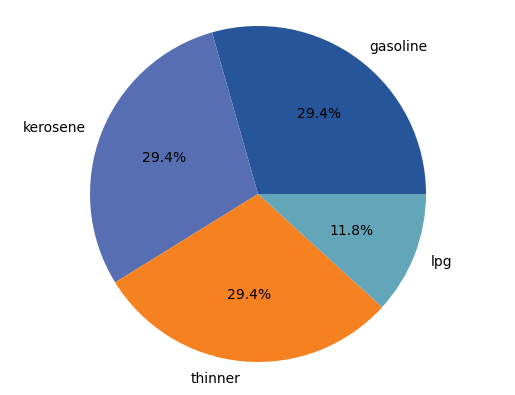

In [19]:
gasoline = dataset.loc[dataset['FUEL'] == 1]
kerosene = dataset.loc[dataset['FUEL'] == 2]
thinner = dataset.loc[dataset['FUEL'] == 3]
lpg = dataset.loc[dataset['FUEL'] == 4]

data = [gasoline.shape[0], kerosene.shape[0], thinner.shape[0], lpg.shape[0]]

fig1, axis = plt.subplots()
colors = ( "#265599","#576eb2","#f58120", "#63a6b9") 
axis.pie(data, colors = colors, labels=['gasoline', 'kerosene', 'thinner',  'lpg'], autopct='%1.1f%%',)
axis.axis('equal')  
plt.show()

As we can see, the sample size for the liquid fuels is much bigger than for lpg. 

<Axes: xlabel='STATUS', ylabel='count'>

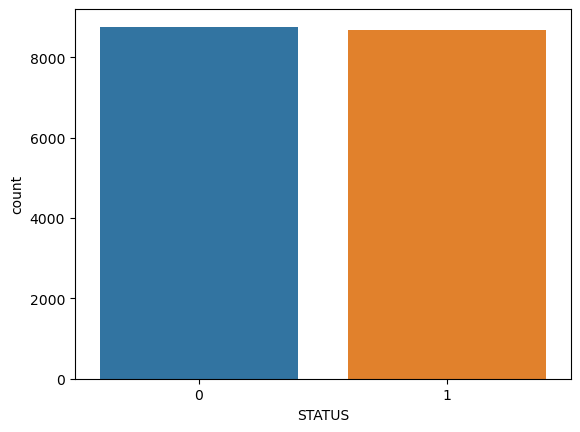

In [20]:
sns.countplot(data = dataset, x='STATUS')

There were similar numbers to the flames that got extinguished and the ones that didn't.

C:\Users\Legion\AppData\Local\Temp\ipykernel_8104\1825868402.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


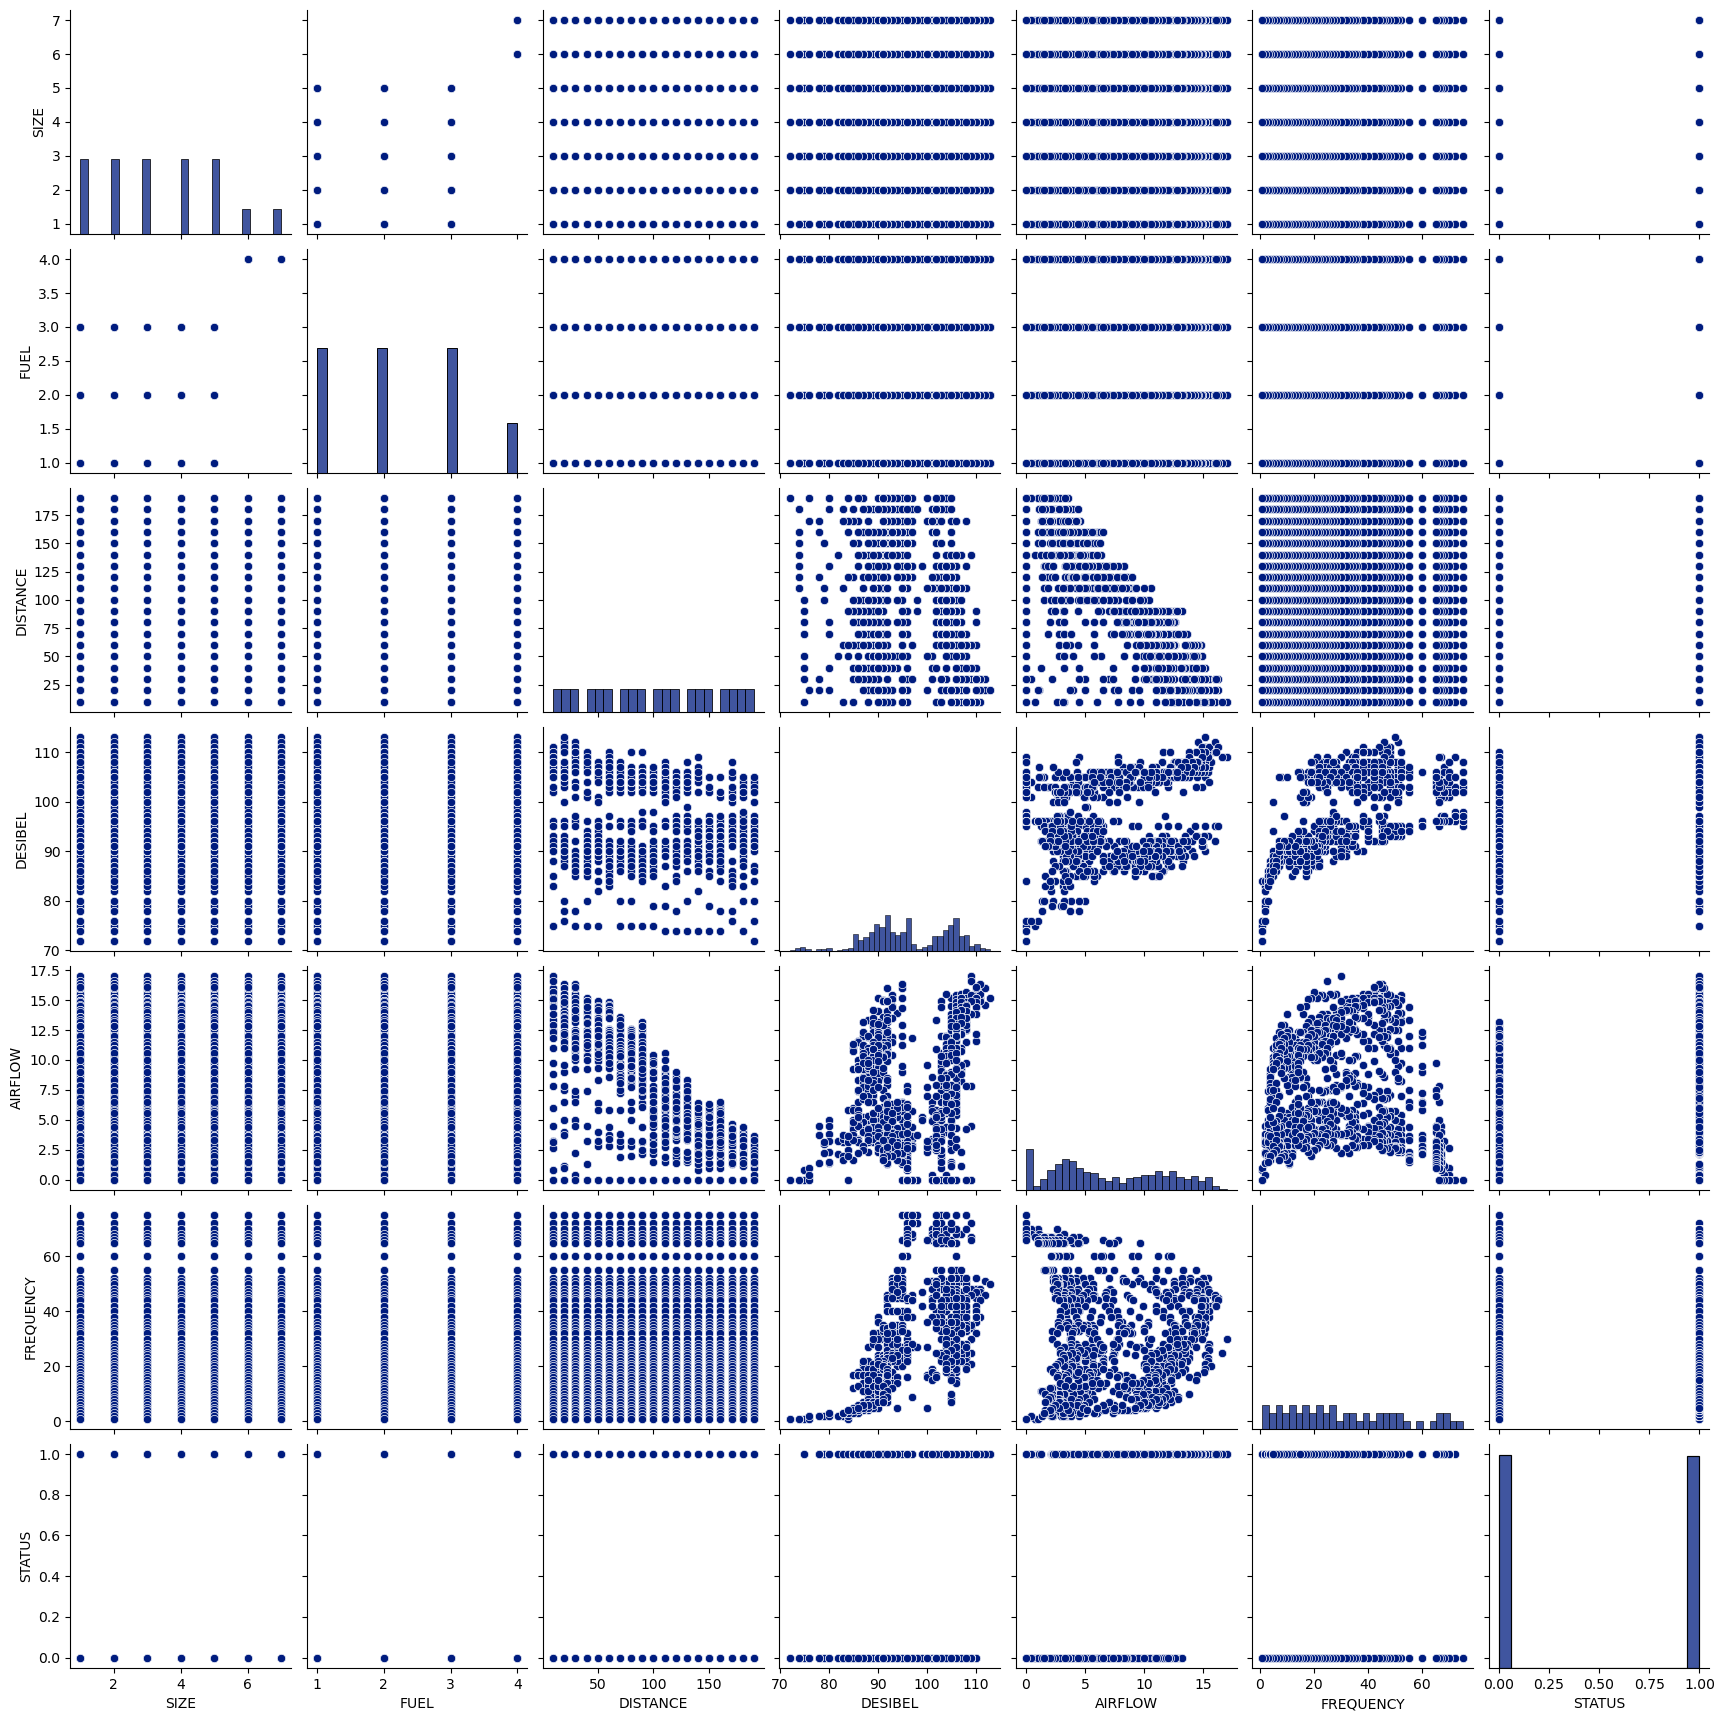

In [21]:
plt.style.use('seaborn-dark-palette')
pair_plot = dataset[['SIZE', 'FUEL', 'DISTANCE', 'DESIBEL', 'AIRFLOW', 'FREQUENCY', 'STATUS']]
sns.pairplot(pair_plot)
plt.show()

<Axes: xlabel='STATUS', ylabel='FUEL'>

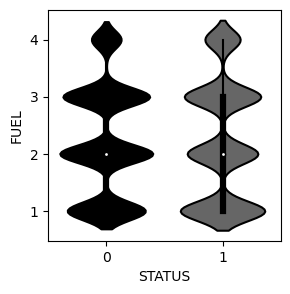

In [22]:
plt.figure(figsize=(3,3))
plt.style.use('grayscale')
sns.violinplot(x='STATUS', y='FUEL', data=dataset)

<Axes: >

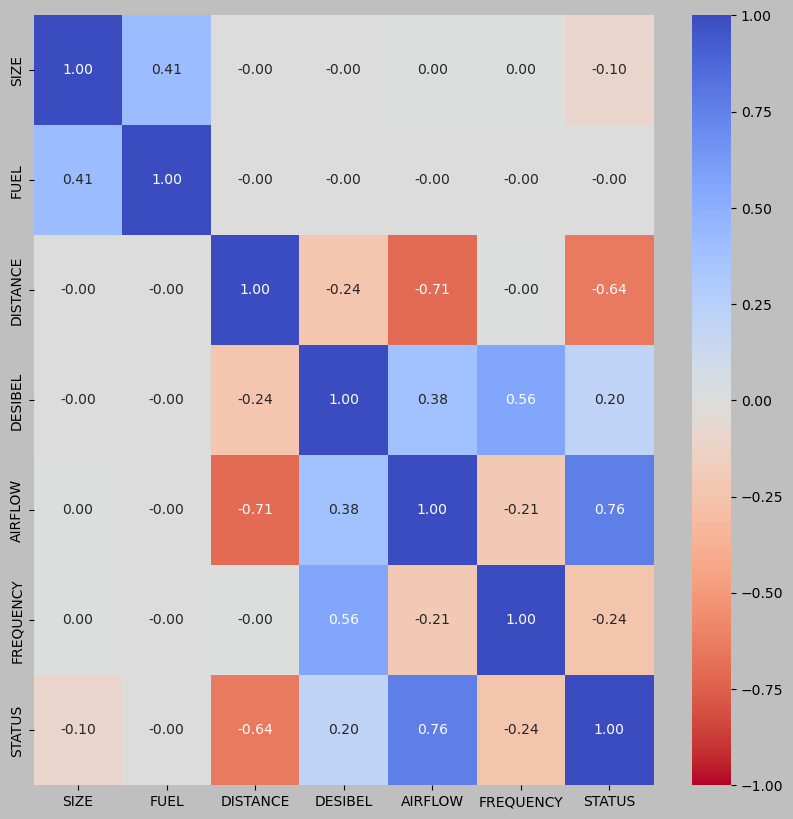

In [23]:
plt.figure(figsize=(10, 10))
cols = ["SIZE", "FUEL", "DISTANCE", "DESIBEL", "AIRFLOW", "FREQUENCY"]

corr = dataset.corr()
sns.heatmap(corr, fmt=".2f", annot=True, cmap='coolwarm_r', vmin=-1, vmax=1)

## Training

We must first decide which columns will serve as input variables and output variables before we can train our model. 
As a result, the output variable will be the column status, which is the one we want to forecast, while the input variables (the other six columns) are utilized to predict whether or not the flame extinguished. We will also create a new column **FUEL_STATUS** to better split the dataset for the model.

In [24]:
# Create a new column that combines FUEL and STATUS
dataset["FUEL_STATUS"] = dataset["FUEL"].astype(str) + "_" + dataset["STATUS"].astype(str)

# input variables
X = dataset.drop(columns=["STATUS", "FUEL_STATUS"])
print(X)

       SIZE  FUEL  DISTANCE  DESIBEL  AIRFLOW  FREQUENCY
0       1.0     1        10       96      0.0         75
1       1.0     1        10       96      0.0         72
2       1.0     1        10       96      2.6         70
3       1.0     1        10       96      3.2         68
4       1.0     1        10      109      4.5         67
...     ...   ...       ...      ...      ...        ...
17437   7.0     4       190       86      2.2          5
17438   7.0     4       190       84      2.0          4
17439   7.0     4       190       80      1.5          3
17440   7.0     4       190       76      0.4          2
17441   7.0     4       190       72      0.0          1

[17442 rows x 6 columns]


In [25]:
# output variables
Y = dataset['STATUS']
print(Y)

0        0
1        1
2        1
3        1
4        1
        ..
17437    0
17438    0
17439    0
17440    0
17441    0
Name: STATUS, Length: 17442, dtype: int64


## Split

Following this, we will divide our data into two groups: the data we will use to train our model and the remaining data to assess the model's effectiveness. We adopted a 30/70 split since we discovered that feeding the model a lot of data was not necessary to train it.
We used stratified sampling to ensure that all fuel types were adequately represented in order to improve performance (this was crucial for LPG because the majority of the data was related to liquid fuels).

In [26]:
# Perform the stratified sampling
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, stratify=dataset["FUEL_STATUS"], random_state=42)

# display the number of observations in each fuel type in the training set
print("Number of observations in each fuel type in the training set:")
print(X_train['FUEL'].value_counts())

print("\nNumber of times the fire extinguished or not in the training set:")
print(Y_train.value_counts())

print("\nNumber of observations in each fuel type in the testing set:")
print(X_test['FUEL'].value_counts())

print("\nNumber of times the fire extinguished or not in the testing set:")
print(Y_test.value_counts())

Number of observations in each fuel type in the training set:
1    1539
3    1539
2    1539
4     615
Name: FUEL, dtype: int64

Number of times the fire extinguished or not in the training set:
0    2627
1    2605
Name: STATUS, dtype: int64

Number of observations in each fuel type in the testing set:
3    3591
1    3591
2    3591
4    1437
Name: FUEL, dtype: int64

Number of times the fire extinguished or not in the testing set:
0    6132
1    6078
Name: STATUS, dtype: int64


## Supervised Learning

### K-Nearest Neighbors

This classifier stores all the available data and classifies a new data point based on proximity or similarity.

In [27]:
knn = KNeighborsClassifier()

knn.fit(X_train, Y_train)
knn_predictions = knn.predict(X_test)

knn_report = classification_report(Y_test, knn_predictions)
knn_cm = confusion_matrix(Y_test, knn_predictions)

print("Classification Report:\n\n", knn_report, "\n\nConfusion Matrix:\n\n", knn_cm)

Classification Report:

               precision    recall  f1-score   support

           0       0.89      0.93      0.91      6132
           1       0.92      0.88      0.90      6078

    accuracy                           0.91     12210
   macro avg       0.91      0.91      0.91     12210
weighted avg       0.91      0.91      0.91     12210
 

Confusion Matrix:

 [[5691  441]
 [ 704 5374]]


### Support Vector Classification

It is based on the Support Vector Machines algorithm and gives predictions based on the side of the gap that a given example falls into.

In [28]:
svc = SVC()

svc.fit(X_train, Y_train)
svc_predictions = svc.predict(X_test)

svc_report = classification_report(Y_test, svc_predictions)
svc_cm = confusion_matrix(Y_test, svc_predictions)

print("Classification Report:\n\n", svc_report, "\n\nConfusion Matrix:\n\n", svc_cm)

Classification Report:

               precision    recall  f1-score   support

           0       0.87      0.91      0.89      6132
           1       0.90      0.86      0.88      6078

    accuracy                           0.88     12210
   macro avg       0.88      0.88      0.88     12210
weighted avg       0.88      0.88      0.88     12210
 

Confusion Matrix:

 [[5564  568]
 [ 868 5210]]


### Decision Trees

This classifier follows a tree like model of decisons. It splits the data recursively based on the most significant feature of each node.

In [29]:
dt_classifier = DecisionTreeClassifier()

dt_classifier.fit(X_train, Y_train)
dt_predictions = dt_classifier.predict(X_test)

dt_report = classification_report(Y_test, dt_predictions)
dt_cm = confusion_matrix(Y_test, dt_predictions)

print("Classification Report:\n\n", dt_report, "\n\nConfusion Matrix:\n\n", dt_cm)

Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.95      0.94      6132
           1       0.95      0.94      0.94      6078

    accuracy                           0.94     12210
   macro avg       0.94      0.94      0.94     12210
weighted avg       0.94      0.94      0.94     12210
 

Confusion Matrix:

 [[5808  324]
 [ 370 5708]]


### Neural Networks

It is operated by many algorithms that work together in order to recognize patterns in a set of data and make predictions, mimicking the process in the human brain.

In [30]:
nn_classifier = MLPClassifier()

nn_classifier.fit(X_train, Y_train)
nn_predictions = nn_classifier.predict(X_test)

nn_report = classification_report(Y_test, dt_predictions)
nn_cm = confusion_matrix(Y_test, dt_predictions)

print("Classification Report:\n\n", nn_report, "\n\nConfusion Matrix:\n\n", nn_cm)

Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.95      0.94      6132
           1       0.95      0.94      0.94      6078

    accuracy                           0.94     12210
   macro avg       0.94      0.94      0.94     12210
weighted avg       0.94      0.94      0.94     12210
 

Confusion Matrix:

 [[5808  324]
 [ 370 5708]]


## Improving Algorithms

### K-Nearest Neighbors

In [31]:
param_grid = {
    'n_neighbors': [3, 5, 7],  # Specify the values of K (number of neighbors)
    'weights': ['uniform', 'distance'],  # Specify the weight function
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Specify the algorithm
    'p': [1, 2]  # Specify the power parameter for Minkowski distance (1 for Manhattan, 2 for Euclidean)
}

# Create classifier
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(X_train, Y_train)

Y_pred = grid_search.predict(X_test)

print("Best param: ", grid_search.best_params_)

Best param:  {'algorithm': 'brute', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}


<Axes: >

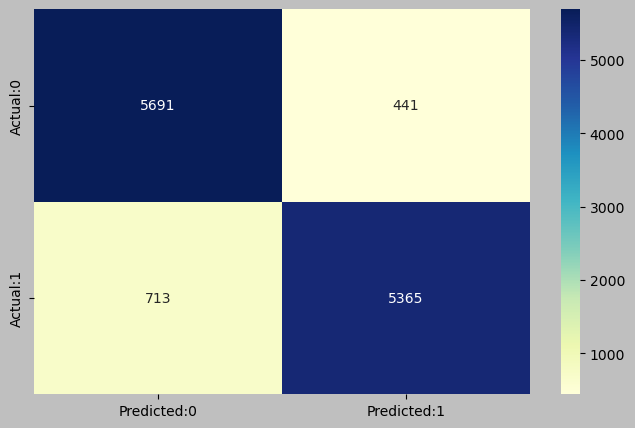

In [32]:
# Y_test values from dataset
# Y_pred values from predictions
cm = confusion_matrix(Y_test, Y_pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'],index = ['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [33]:
accuracy = round(accuracy_score(Y_test,Y_pred),2)
auc = round(roc_auc_score(Y_test,Y_pred),2)
print("Accuracy: ", accuracy)
print("ROC AUC Score: ", auc)

Accuracy:  0.91
ROC AUC Score:  0.91


### Support Vector Classification

In [ ]:
# Create classifier
svc = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.5, 1.0],
    'shrinking': [True, False],
    'probability': [True, False],
    'tol': [0.001, 0.01, 0.1],
    'class_weight': [None, 'balanced'],
    'verbose': [0, 1, 2]
}

grid_search = GridSearchCV(svc, param_grid, cv=5)

grid_search.fit(X_train, Y_train) 

Y_pred = grid_search.predict(X_test)

print("Best param: ", grid_search.best_params_)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [ ]:
# Y_test values from dataset
# Y_pred values from predictions
cm = confusion_matrix(Y_test, Y_pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'],index = ['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [ ]:
accuracy = round(accuracy_score(Y_test,Y_pred),2)
auc = round(roc_auc_score(Y_test,Y_pred),2)
print("Accuracy: ", accuracy)
print("ROC AUC Score: ", auc)

### Decision Tree

In [35]:
# Create classifier
dt = tree.DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [32, 64, 128],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(dt, param_grid, cv=5)

grid_search.fit(X_train, Y_train) 

Y_pred = grid_search.predict(X_test)

print("Best param: ", grid_search.best_params_)

Best param:  {'criterion': 'entropy', 'max_depth': 128, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


<Axes: >

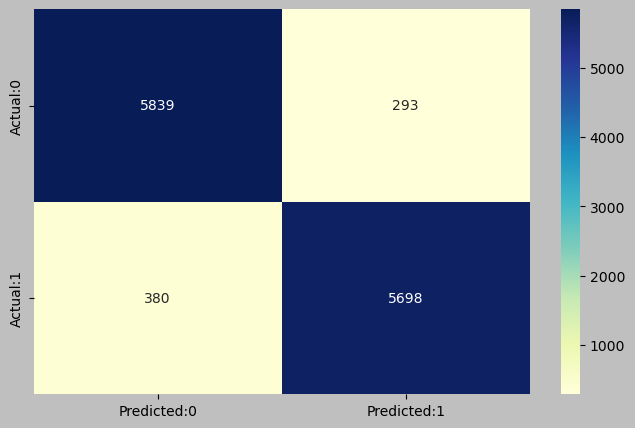

In [36]:
# Y_test values from dataset
# Y_pred values from predictions
cm = confusion_matrix(Y_test, Y_pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'],index = ['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [37]:
accuracy = round(accuracy_score(Y_test,Y_pred),2)
auc = round(roc_auc_score(Y_test,Y_pred),2)
print("Accuracy: ", accuracy)
print("ROC AUC Score: ", auc)

Accuracy:  0.94
ROC AUC Score:  0.94


### Neural Network

In [38]:
# Create classifier
nn = MLPClassifier()

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(nn, param_grid, cv=5)

grid_search.fit(X_train, Y_train) 

Y_pred = grid_search.predict(X_test)

print("Best param: ", grid_search.best_params_)

C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_

C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_

Best param:  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


C:\Users\Legion\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: >

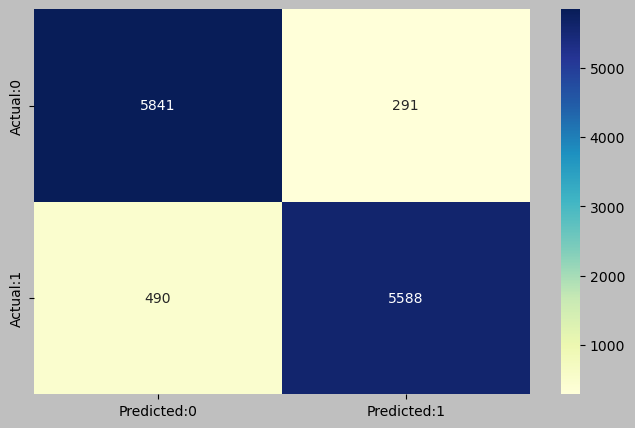

In [39]:
# Y_test values from dataset
# Y_pred values from predictions
cm = confusion_matrix(Y_test, Y_pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'],index = ['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [40]:
accuracy = round(accuracy_score(Y_test,Y_pred),2)
auc = round(roc_auc_score(Y_test,Y_pred),2)
print("Accuracy: ", accuracy)
print("ROC AUC Score: ", auc)

Accuracy:  0.94
ROC AUC Score:  0.94
